The [new editor retention rate](https://meta.wikimedia.org/wiki/Research:Surviving_new_editor) suddenly spiked among the January 2018 cohort of new editors. Is this real and, if so, what caused it?

In [2]:
import datetime as dt

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

/home/neilpquinn-wmf/venv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import wmfdata as wmf

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [109]:
# Customize Matplotlib styles
%matplotlib inline
mpl.rcParams["font.size"] = 18
mpl.rcParams["figure.figsize"] = (16, 10)
pct_ax = mpl.ticker.PercentFormatter(xmax=1)

# Data imports and transformation

## Monthly aggregates

In [6]:
glob_mo = pd.read_table("data/adl_global_monthly_retention.tsv")
glob_mo["reg_mo"] = pd.to_datetime(glob_mo["reg_mo"])
glob_mo = glob_mo.set_index("reg_mo")
glob_mo.head()

,new_eds,ret
reg_mo,,
2001-01-01,6,0.500000
2001-02-01,5,0.600000
2001-03-01,13,0.538462
2001-04-01,11,0.272727
2001-05-01,13,0.615385


In [7]:
glob_mo.tail()

,new_eds,ret
reg_mo,,
2017-10-01,110347,0.074211
2017-11-01,110464,0.054036
2017-12-01,97736,0.052366
2018-01-01,113366,0.077360
2018-02-01,103494,0.066922


In [8]:
proj_mo = pd.read_table("data/adl_project_monthly_retention.tsv")
proj_mo["reg_mo"] = pd.to_datetime(proj_mo["reg_mo"])
proj_mo.head()

,wiki,reg_mo,new_eds,ret
0,abwiki,2004-01-01,1,0.0
1,abwiki,2004-08-01,1,0.0
2,abwiki,2004-11-01,2,0.0
3,abwiki,2004-12-01,2,0.5
4,abwiki,2005-01-01,1,0.0


## English Wikipedia new editors

### Revisions from MariaDB

In [9]:
mdb_en_revs = pd.read_table(
    "data/mdb_enwiki_new_editor_revisions.tsv",
    parse_dates=["reg_dt", "rev_dt"],
    dtype={
        "mob": np.bool,
        "ve": np.bool
    }
)

td_30 = dt.timedelta(days = 30)
td_60 = dt.timedelta(days = 60)

mdb_en_revs["since_reg"] = mdb_en_revs["rev_dt"] - mdb_en_revs["reg_dt"]
mdb_en_revs["mo_1"] = mdb_en_revs["since_reg"] < td_30
mdb_en_revs["mo_2"] = (mdb_en_revs["since_reg"] >= td_30) & (mdb_en_revs["since_reg"] < td_60)

mdb_en_revs = mdb_en_revs.query("mo_1 == True | mo_2 == True")

mdb_en_revs.head()

,name,rev_id,reg_dt,rev_dt,mob,ve,since_reg,mo_1,mo_2
0,HappyPaige627,752388509,2016-12-01 00:00:15,2016-12-01 00:01:48,False,False,00:01:33,True,False
1,Toppu Kaeru,752389022,2016-12-01 00:01:09,2016-12-01 00:04:02,False,False,00:02:53,True,False
2,GAdams,752389051,2016-12-01 00:03:08,2016-12-01 00:04:09,True,False,00:01:01,True,False
3,Albitr,752389167,2016-12-01 00:00:34,2016-12-01 00:04:44,False,True,00:04:10,True,False
4,Ltclaws,752390193,2016-12-01 00:02:26,2016-12-01 00:09:38,False,True,00:07:12,True,False


In [10]:
rate = lambda x: np.sum(x) / len(x)

mdb_en_new = mdb_en_revs.groupby("name").agg({
    "reg_dt": {"reg_day": lambda x: dt.datetime.date(np.min(x))},
    "mo_1": {"mo_1_revs": np.sum},
    "mo_2": {"mo_2_revs": np.sum},
    "mob": {"mob_revs": np.sum, "mob_rate": rate},
    "ve": {"ve_revs": np.sum, "ve_rate": rate}
})


/home/neilpquinn-wmf/venv/lib/python3.5/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [11]:
# Flatten the multi-level column labels
mdb_en_new.columns = [col[1] for col in mdb_en_new.columns]

mdb_en_new.head()

,mob_revs,mob_rate,mo_1_revs,mo_2_revs,reg_day,ve_revs,ve_rate
name,,,,,,,
!!Ethereal!!,0.0,0.0,2.0,0.0,2018-02-06,0.0,0.0
!!Hûm Såfår!!,2.0,1.0,2.0,0.0,2017-02-23,1.0,0.5
!.Jimiey.!,0.0,0.0,2.0,0.0,2016-12-17,2.0,1.0
!0Clarke,0.0,0.0,3.0,0.0,2018-01-06,0.0,0.0
!0MinutesADay,0.0,0.0,1.0,0.0,2017-11-17,0.0,0.0


In [12]:
mdb_en_d = mdb_en_new.groupby("reg_day").agg({
    "mo_1_revs": {"mo_1_eds": np.count_nonzero, "mo_1_revs": np.sum},
    "mo_2_revs": {"mo_2_eds": np.count_nonzero, "mo_2_revs": np.sum},
    "mob_revs": {"mob_revs": np.sum},
    "ve_revs": {"ve_revs": np.sum},
    "mob_rate": {"avg_mob_rate": np.mean},
    "ve_rate": {"avg_ve_rate": np.mean}
})

# Flatten the multi-level column labels
mdb_en_d.columns = [col[1] for col in mdb_en_d.columns]

# Calculate retention
mdb_en_d["ret"] = mdb_en_d["mo_2_eds"] / mdb_en_d["mo_1_eds"]

mdb_en_d.head()

/home/neilpquinn-wmf/venv/lib/python3.5/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,mob_revs,mo_2_eds,mo_2_revs,avg_mob_rate,mo_1_revs,mo_1_eds,ve_revs,avg_ve_rate,ret
reg_day,,,,,,,,,
2016-12-01,1342.0,85.0,1135.0,0.279193,8121.0,1470.0,2175.0,0.231316,0.057823
2016-12-02,1337.0,79.0,1534.0,0.262229,7260.0,1459.0,1065.0,0.193966,0.054147
2016-12-03,1538.0,74.0,973.0,0.367131,7051.0,1211.0,734.0,0.179363,0.061107
2016-12-04,1385.0,77.0,1178.0,0.334723,5830.0,1293.0,976.0,0.194578,0.059551
2016-12-05,1287.0,84.0,1079.0,0.282791,6732.0,1509.0,1067.0,0.194499,0.055666


### Revisions from the Analytics Data Lake

In [13]:
adl_en_new = pd.read_table("data/adl_enwiki_new_editors.tsv", parse_dates = ["reg_day"])
adl_en_new.head()

,name,reg_day,mo_1_revs,mo_2_revs,mo_1_reverts,mo_2_reverts
0,!!Ethereal!!,2018-02-06,2,0,0,0
1,!!Hûm Såfår!!,2017-02-23,4,0,1,0
2,!.Jimiey.!,2016-12-17,2,0,2,0
3,!0Clarke,2018-01-06,3,0,1,0
4,!0MinutesADay,2017-11-17,1,0,0,0


In [14]:
adl_en_d = adl_en_new.groupby("reg_day").agg({
    "mo_1_revs": {"mo_1_eds": np.count_nonzero, "mo_1_revs": np.sum},
    "mo_2_revs": {"mo_2_eds": np.count_nonzero, "mo_2_revs": np.sum},
    "mo_1_reverts": {"mo_1_reverts": np.sum},
    "mo_2_reverts": {"mo_2_reverts": np.sum}
})

# Flatten the multi-level column labels
adl_en_d.columns = [col[1] for col in adl_en_d.columns]

# Calculate retention
adl_en_d["ret"] = adl_en_d["mo_2_eds"] / adl_en_d["mo_1_eds"]

adl_en_d.head()

/home/neilpquinn-wmf/venv/lib/python3.5/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,mo_2_reverts,mo_1_revs,mo_1_eds,mo_1_reverts,mo_2_eds,mo_2_revs,ret
reg_day,,,,,,,
2016-12-01,149,9275,1692,2294,73,967,0.043144
2016-12-02,206,8890,1657,1957,71,1618,0.042849
2016-12-03,114,8280,1370,1905,69,1079,0.050365
2016-12-04,103,6973,1453,1626,60,1158,0.041294
2016-12-05,144,8310,1711,1987,73,1279,0.042665


### Daily aggregates

In [15]:
en_d = adl_en_d.join(mdb_en_d, lsuffix = "_adl", rsuffix="_mdb")
en_d["mo_1_revert_rate"] = en_d["mo_1_reverts"] / en_d["mo_1_revs_adl"]

In [16]:
en_d.head()

,mo_2_reverts,mo_1_revs_adl,mo_1_eds_adl,mo_1_reverts,mo_2_eds_adl,mo_2_revs_adl,ret_adl,mob_revs,mo_2_eds_mdb,mo_2_revs_mdb,avg_mob_rate,mo_1_revs_mdb,mo_1_eds_mdb,ve_revs,avg_ve_rate,ret_mdb,mo_1_revert_rate
reg_day,,,,,,,,,,,,,,,,,
2016-12-01,149,9275,1692,2294,73,967,0.043144,1342.0,85.0,1135.0,0.279193,8121.0,1470.0,2175.0,0.231316,0.057823,0.247332
2016-12-02,206,8890,1657,1957,71,1618,0.042849,1337.0,79.0,1534.0,0.262229,7260.0,1459.0,1065.0,0.193966,0.054147,0.220135
2016-12-03,114,8280,1370,1905,69,1079,0.050365,1538.0,74.0,973.0,0.367131,7051.0,1211.0,734.0,0.179363,0.061107,0.230072
2016-12-04,103,6973,1453,1626,60,1158,0.041294,1385.0,77.0,1178.0,0.334723,5830.0,1293.0,976.0,0.194578,0.059551,0.233185
2016-12-05,144,8310,1711,1987,73,1279,0.042665,1287.0,84.0,1079.0,0.282791,6732.0,1509.0,1067.0,0.194499,0.055666,0.239110


In [17]:
en_d_r = en_d.rolling(7).mean()

# Retention throughout history

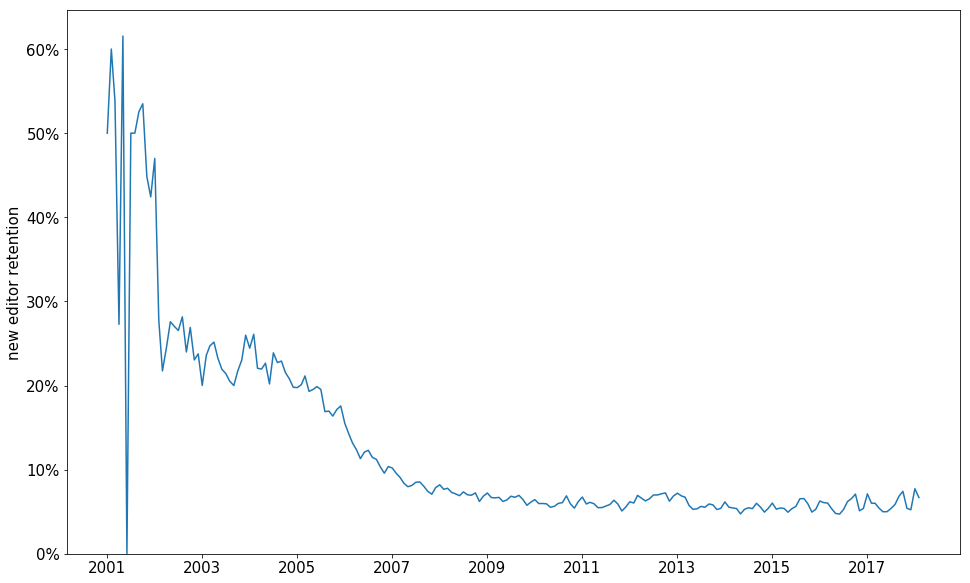

In [20]:
plt.plot(glob_mo["ret"])
plt.gca().yaxis.set_major_formatter(pct_ax)
plt.ylabel("new editor retention")
plt.ylim(ymin=0);

Without the pre-2005 insanity:

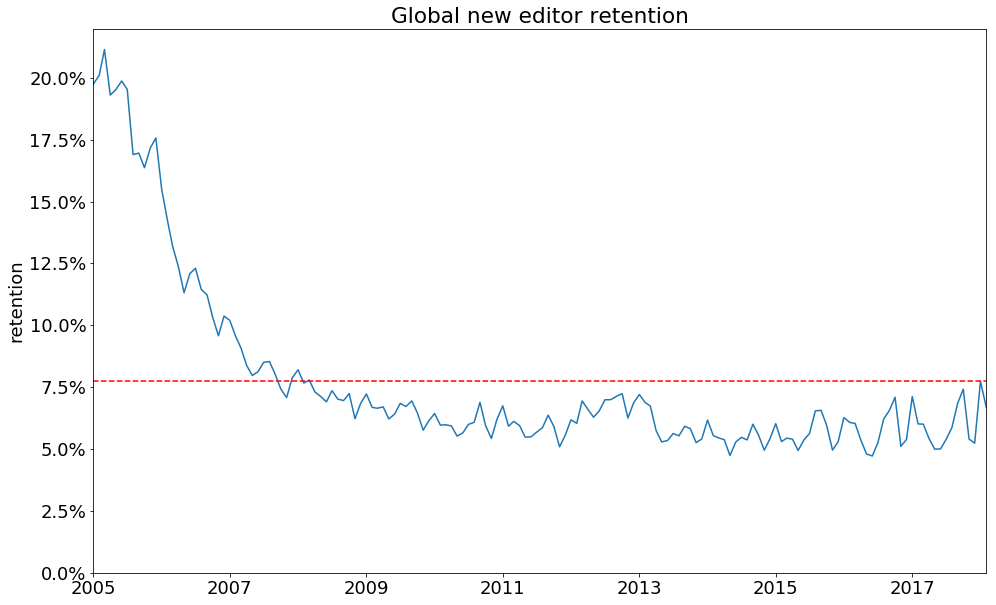

In [112]:
plt.plot(glob_mo["ret"][jan_2005:])
ax = plt.gca()
ax.yaxis.ticker.StrMethodFormatter(pct_ax)
ax.axhline(
    y=glob_mo.loc[dt.datetime(2018, 1, 1), "ret"],
    color = "red", 
    linestyle = "--"
)
plt.title("Global new editor retention")
plt.autoscale(enable=True, axis="x", tight=True)
plt.ylabel("retention")
plt.ylim(ymin=0);

Just the past 7 years:

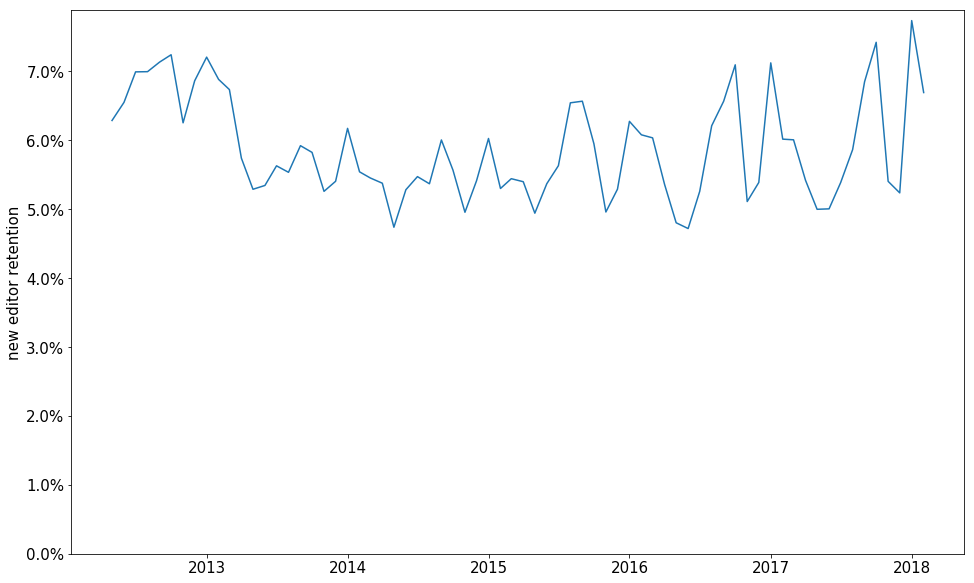

In [26]:
back_7_years = dt.datetime(2011, 5, 1)
plt.plot(glob_mo["ret"][back_6_years:])
plt.gca().yaxis.set_major_formatter(pct_ax)
plt.ylabel("new editor retention")
plt.ylim(ymin=0);

# The scene of the crime: English Wikipedia

In [50]:
def global_retention(df):
    return (df["new_eds"] * df["ret"]).sum() / df["new_eds"].sum()

en_mo = proj_mo.query("wiki == 'enwiki'").groupby("reg_mo").apply(global_retention)
non_en_mo = proj_mo.query("wiki != 'enwiki'").groupby("reg_mo").apply(global_retention)

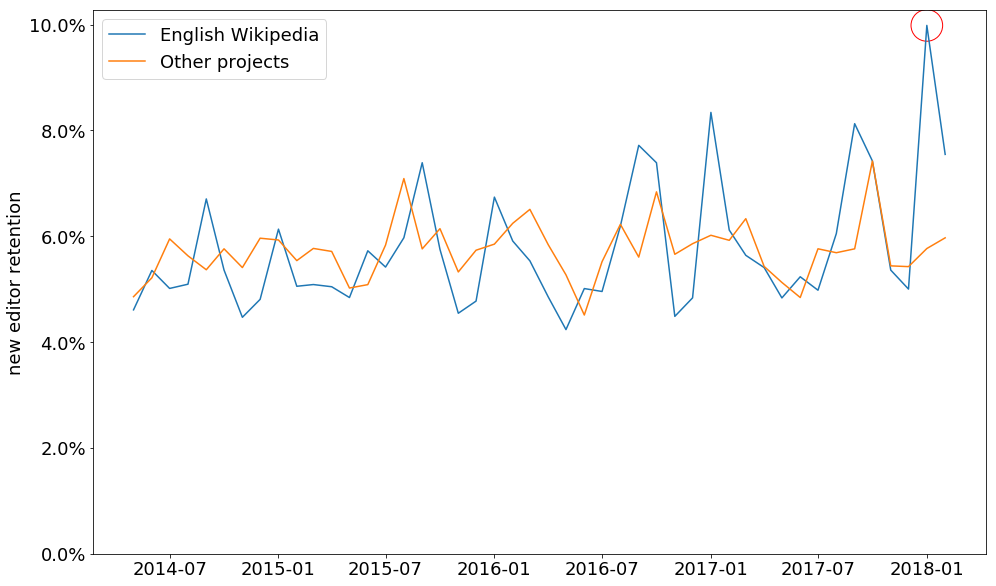

In [113]:
ax.cla()
plt.plot(en_mo[back_4_years:], label="English Wikipedia")
plt.plot(non_en_mo[back_4_years:], label="Other projects")
plt.gca().yaxis.set_major_formatter(pct_ax)
plt.ylabel("new editor retention")
plt.legend()
plt.ylim(ymin=0)
ax = plt.gca()
ax.scatter(jan_2018, en_mo[dt.datetime(2018, 1, 1)], s = 1000, facecolors="none", edgecolors="red")
plt.show()

The Analytics Data Lake and MariaDB numbers won't match because the MariaDB numbers exclude deleted users, but let's see if the trends are the same.

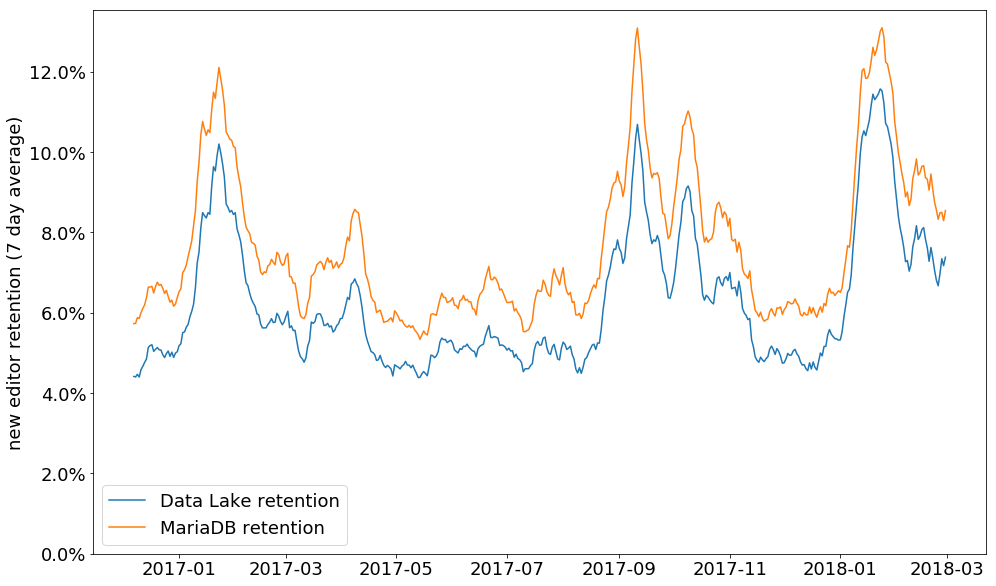

In [119]:
plt.plot(en_d_r["ret_adl"], label="Data Lake retention")
plt.plot(en_d_r["ret_mdb"], label="MariaDB retention")
plt.gca().yaxis.set_major_formatter(pct_ax)
plt.ylabel("new editor retention (7 day average)")
plt.legend()
plt.ylim(ymin=0);

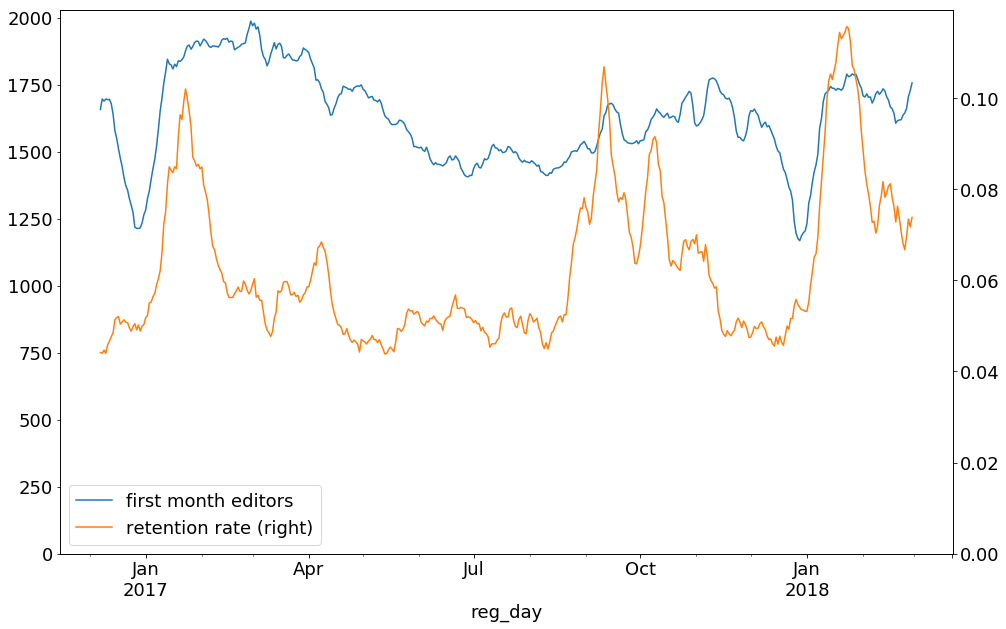

In [134]:
ax = en_d_r.mo_1_eds_adl.plot(label="first month editors", legend=True, ylim = 0)
en_d_r.ret_adl.plot(secondary_y=True, label="retention rate", legend=True)
ax.right_ax.set_ylim(0);

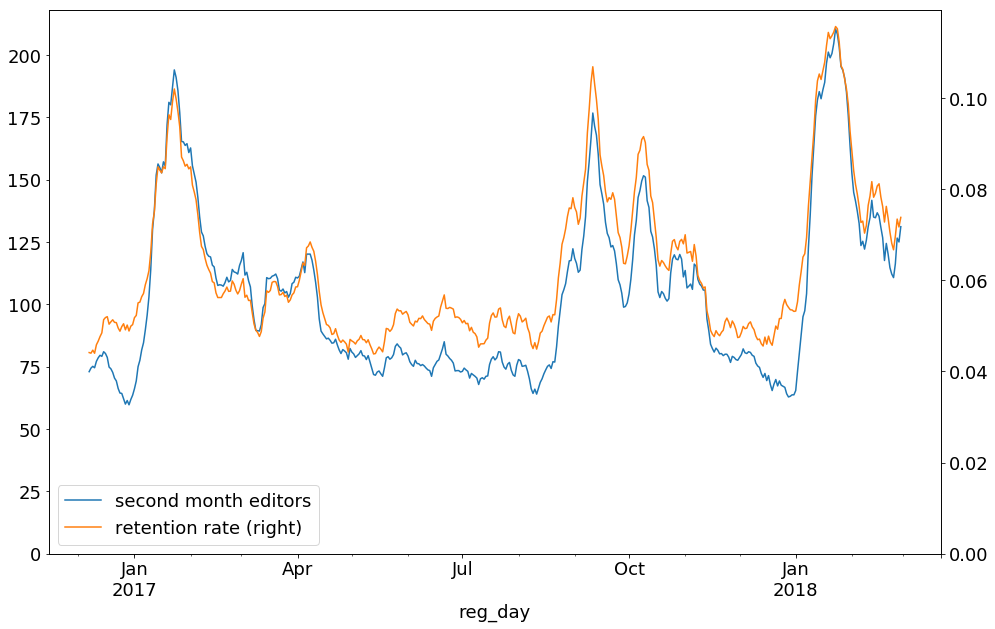

In [135]:
ax = en_d_r.mo_2_eds_adl.plot(label="second month editors", legend=True, ylim = 0)
en_d_r.ret_adl.plot(secondary_y=True, label="retention rate", legend=True)
ax.right_ax.set_ylim(0);

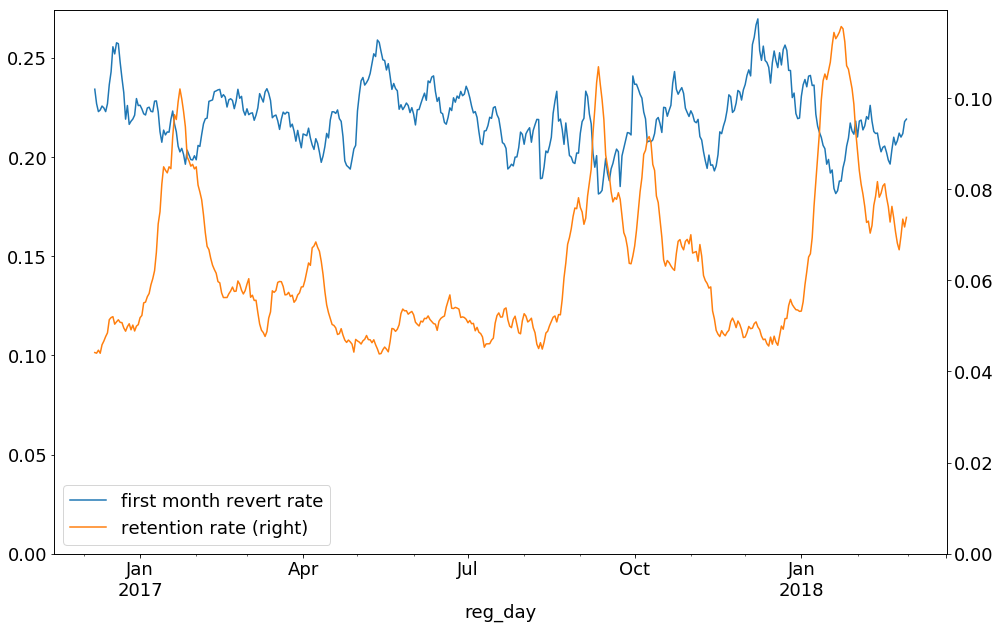

In [121]:
ax = en_d_r.mo_1_revert_rate.plot(label="first month revert rate", legend=True, ylim=0)
en_d_r.ret_adl.plot(secondary_y=True, label="retention rate", legend=True)
ax.right_ax.set_ylim(0);

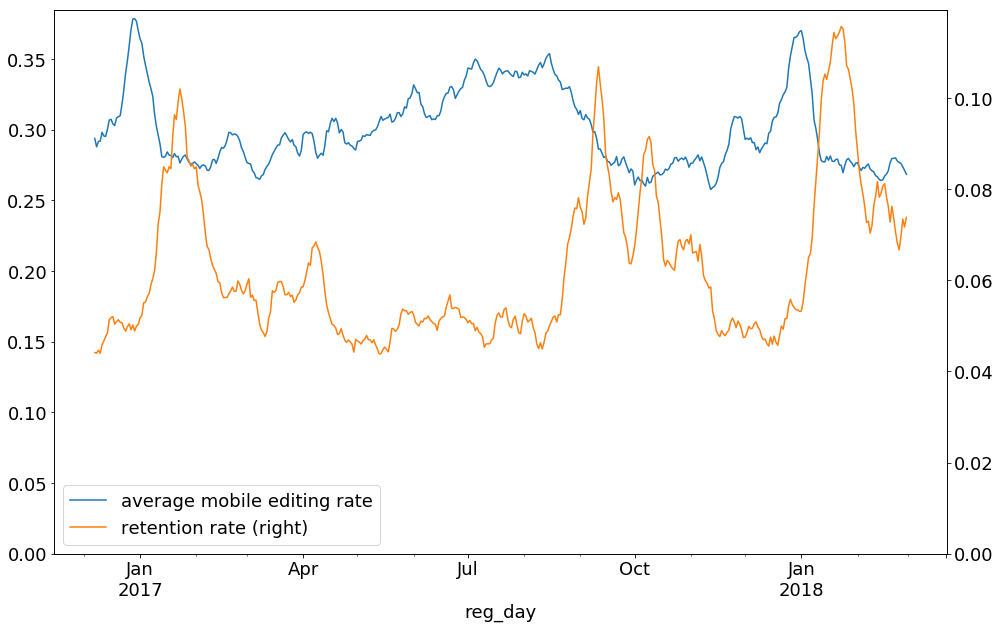

In [124]:
ax = en_d_r.avg_mob_rate.plot(label="average mobile editing rate", legend=True, ylim = 0)
en_d_r.ret_adl.plot(secondary_y=True, label="retention rate", legend=True)
ax.right_ax.set_ylim(0);

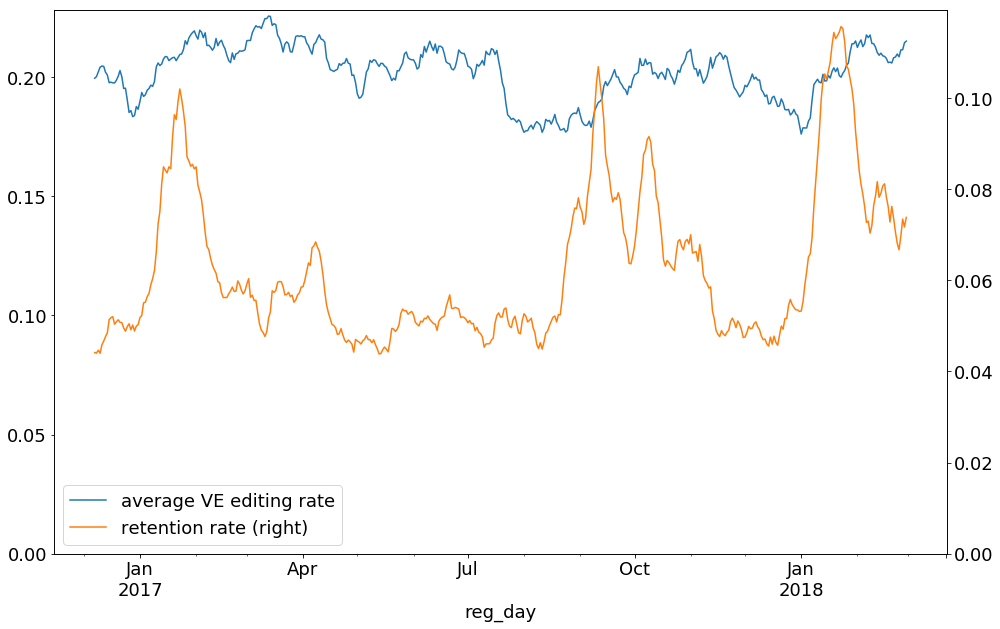

In [125]:
ax = en_d_r.avg_ve_rate.plot(label="average VE editing rate", legend=True, ylim = 0)
en_d_r.ret_adl.plot(secondary_y=True, label="retention rate", legend=True)
ax.right_ax.set_ylim(0);

# Seasonal effects

Retention is lower among people who register on Saturdays and Sundays.

In [136]:
day_ret = pd.DataFrame(en_d["ret_adl"]).reset_index()

In [138]:
day_ret["day"] = day_ret["reg_day"].apply(lambda x: x.weekday())

In [142]:
# 0 is Monday, 6 is Sunday
day_ret.groupby("day")["ret_adl"].mean()

day
0    0.063744
1    0.066281
2    0.065893
3    0.065604
4    0.064311
5    0.055171
6    0.056985
Name: ret_adl, dtype: float64

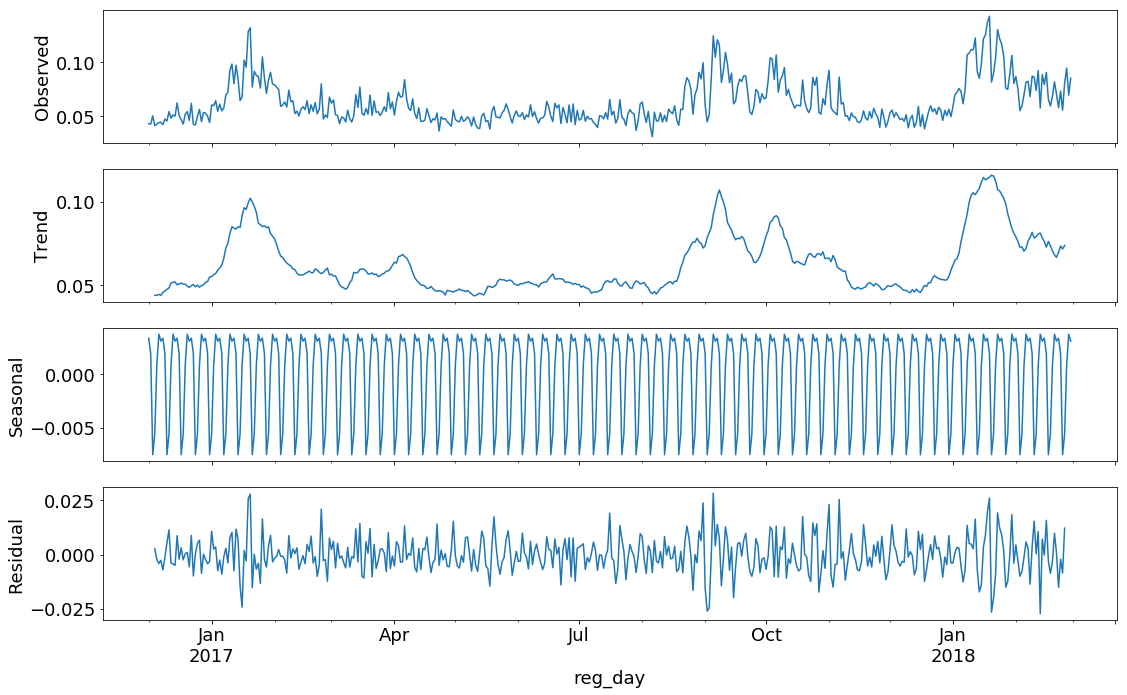

In [140]:
result = seasonal_decompose(en_d["ret_adl"], model='additive', freq=7)
result.plot()
plt.show()

Retention peaks in January and September, which seems likely to be related to students and higher education.

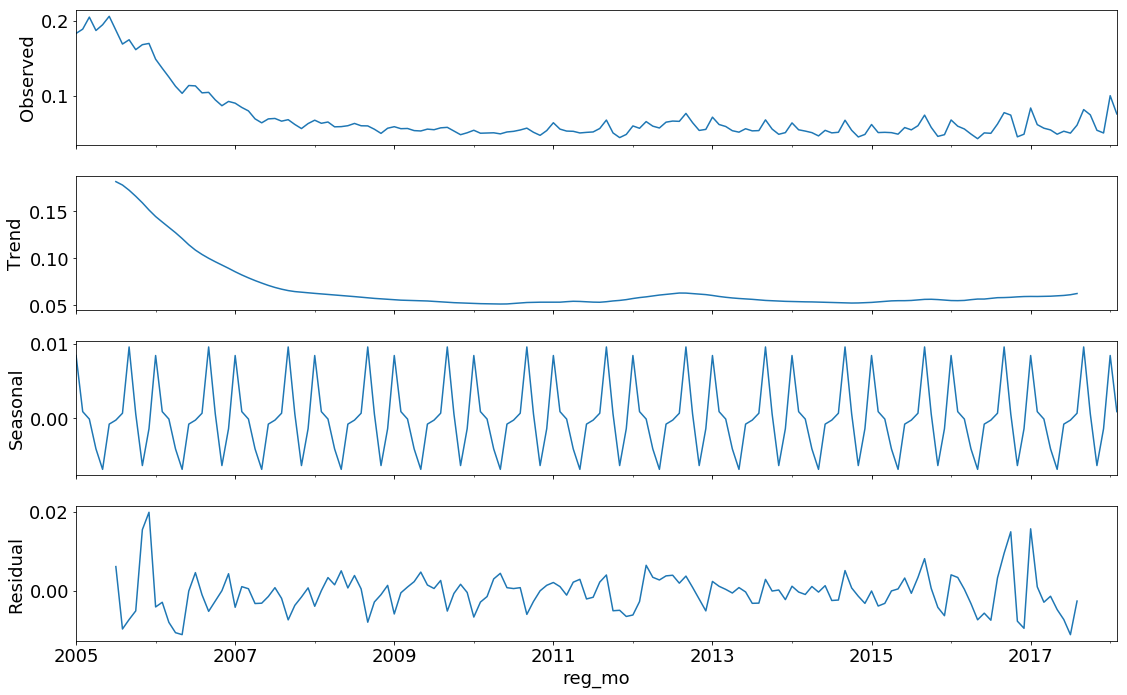

In [143]:
result = seasonal_decompose(en_mo[jan_2005:], model='additive', freq=12)
result.plot()
plt.autoscale(enable=True, axis="x", tight=True)

In [144]:
mo_seas = pd.DataFrame(result.seasonal).reset_index()

In [145]:
mo_seas["mo"] = mo_seas["reg_mo"].apply(lambda x: x.month)

In [146]:
mo_seas = mo_seas.rename(columns={0: "seasonal_fluctuation", "mo": "month_of_the_year"})

In [148]:
mo_dev = mo_seas.groupby("month_of_the_year").mean()
mo_dev.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
mo_dev

,seasonal_fluctuation
Jan,0.008396
Feb,0.000866
Mar,-0.000131
Apr,-0.004135
May,-0.006879
Jun,-0.000810
Jul,-0.000275
Aug,0.000652
Sep,0.009544
Oct,0.000562


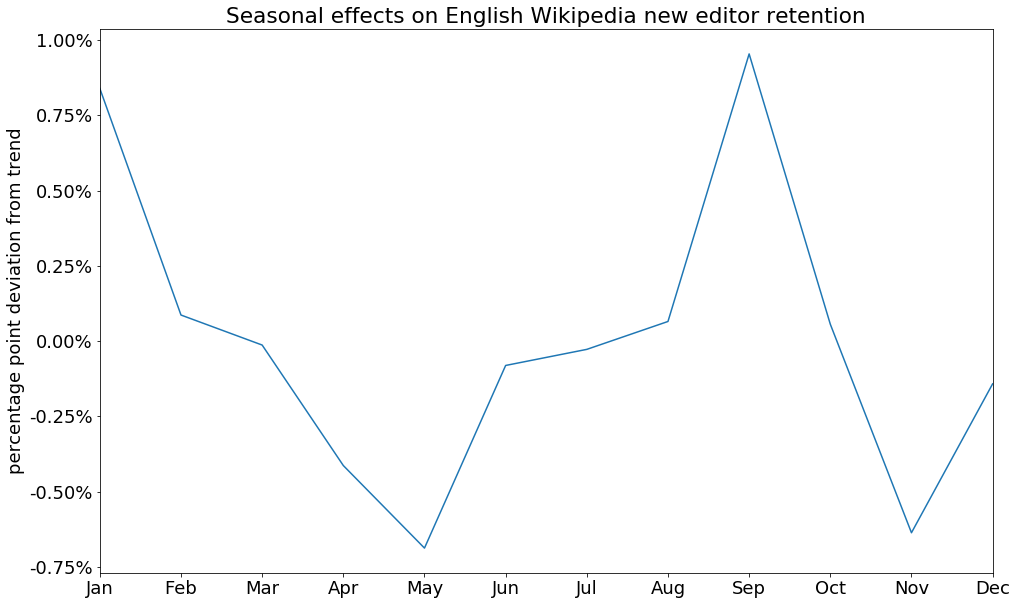

In [149]:
plt.plot(mo_dev)
plt.title("Seasonal effects on English Wikipedia new editor retention")
plt.gca().yaxis.set_major_formatter(pct_ax)
plt.gca().set_ylabel("percentage point deviation from trend")
plt.autoscale(enable=True, axis="x", tight=True)